# Импорт библиотек

In [1]:
pip install pymorphy2

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import BertTokenizer
from gensim.models import Word2Vec
from transformers import AdamW
from tqdm import tqdm
from transformers import BertModel
import torch.nn as nn
from nltk.corpus import stopwords
import pymorphy2
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Гружу данные напрямую с кагля

In [3]:
#! pip install kaggle

In [4]:
#! mkdir ~/.kaggle

In [5]:
#! cp kaggle.json ~/.kaggle/

In [6]:
#! chmod 600 ~/.kaggle/kaggle.json

In [7]:
#! kaggle competitions download -c study-competition-3-dl-2024

In [8]:
#!unzip study-competition-3-dl-2024.zip

# 1) Поизучать данные, провести их исследование и очистку. Разбить данные на трейн-валидацию-тест

In [9]:
#data_train = pd.read_csv('train.csv' , sep = ';')
#data_test = pd.read_csv('test.csv' , sep =';')
#sample_submission = pd.read_csv('sample_submission.csv' , sep = ',')

Либо можно просто подгрузить с гугол диска

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
data_train = pd.read_csv('drive/MyDrive/train.csv' , sep = ';')
data_test = pd.read_csv('drive/MyDrive/test.csv' , sep = ';')
sample_submission = pd.read_csv('drive/MyDrive/sample_submission.csv')

In [12]:
data_train

,id,comment,toxic
0,0,Бесполезно что-то пытаться донести так до люде...,0
1,1,А свиньи разве умеют читать?\n,1
2,2,Червепидорские страны парашной конфедерации -К...,1
3,3,"Нет, это не так. Я зашёл сюда специально за эт...",1
4,4,"Дополнение: Дентрен, та чилийская грязь, на ко...",0
...,...,...,...
14995,14995,"""\n\nОбратите внимание: дополнения к категория...",0
14996,14996,Борцовские арены\n\nЯ собираюсь заключить с ва...,0
14997,14997,"Занялась свинособака бесплатно сексом, так еще...",1
14998,14998,"Хуйло, почему ты считаешь что постить с аватар...",1


In [13]:
data_test

,id,comment
0,15000,"Или эти программисты, зарабатывающие 3кк с, вс..."
1,15001,"0,3 с коррекцией, т.е в очках или линзах.\n"
2,15002,"...\n\nДа, здесь все идет. Это моя страница об..."
3,15003,Да. Но отчасти в этом есть вина и самой теслы....
4,15004,нужен баланс между труд отдых зачем? бывали сл...
...,...,...
5407,20407,"Кроме того, в комплектацию входят прибор ночно..."
5408,20408,"На самом деле, вся эта статья нуждается в дора..."
5409,20409,"Фиговый регистратор, можно и 24 часа вместить ..."
5410,20410,"я не из бедной семьи, но в подростковом возрас..."


In [14]:
sample_submission

,ID,prediction
0,15000,0
1,15001,0
2,15002,0
3,15003,0
4,15004,0
...,...,...
5407,20407,0
5408,20408,0
5409,20409,0
5410,20410,0


функция для приведения текста к "общему" виду

In [15]:
def clean_text(text):
    text = text.lower()  # Приведение к нижнему регистру
    text = re.sub(r'\d+', '', text)  # Удаление чисел
    text = re.sub(r'\s+', ' ', text)  # Замена пробелов на одинарный пробел
    text = re.sub(r'\W', ' ', text)  # Удаление пунктуации
    return text

In [16]:
data_train['comment'] = data_train['comment'].apply(clean_text)

In [17]:
data_train

,id,comment,toxic
0,0,бесполезно что то пытаться донести так до люде...,0
1,1,а свиньи разве умеют читать,1
2,2,червепидорские страны парашной конфедерации к...,1
3,3,нет это не так я зашёл сюда специально за эт...,1
4,4,дополнение дентрен та чилийская грязь на ко...,0
...,...,...,...
14995,14995,обратите внимание дополнения к категориям b...,0
14996,14996,борцовские арены я собираюсь заключить с вами ...,0
14997,14997,занялась свинособака бесплатно сексом так еще...,1
14998,14998,хуйло почему ты считаешь что постить с аватар...,1


In [18]:
data_test['comment'] = data_test['comment'].apply(clean_text)

Дропаю айдишники, чтобы не мешались

In [19]:
data_train = data_train.drop(columns= 'id')

Посмотрим на распределение классов в датасете: заметен явный дизбаланс, так как положительных комментариев куда больше

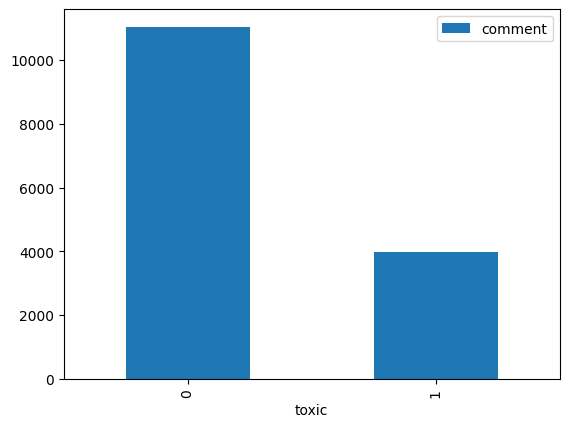

In [20]:
data_train.groupby('toxic').count().plot(kind = 'bar');

In [21]:
data_train['toxic'].value_counts()

toxic
0    11038
1     3962
Name: count, dtype: int64

Чтобы избавиться от проблемы дизбаланса классов и одновременно выполнить пункт 2, проведу аугментацию данных путем расширения тренировочный выборки с помощью использования другого датасета, взятого [тут](https://www.kaggle.com/datasets/alexandersemiletov/toxic-russian-comments)
Это датасет собран был в одноклассниках и содержит примерно 250 тыс комментариев разной степени отбитости, токсисные комментарии помечены как оскорбление, угроза и непристойность - я же обобщил их в класс токсисных (по идее так будет шире выборка для определения токсичных слов)

#2) Провести аугментацию данных, не используя тот же датасет из открытого доступа. Можно спарсить данные или найти новые схожие датасеты (даже можно найти на иностранном языке и перевести, используя качественные готовые переводчики)

In [22]:
data_list = []
with open("drive/MyDrive/dataset.txt", encoding='utf-8') as file:
    for line in file:
        labels = line.split()[0]
        text = line[len(labels)+1:].strip()
        labels = labels.split(",")
        toxic = 0 if "__label__NORMAL" in labels else 1
        data_list.append((text, toxic))

In [23]:
extra_data = pd.DataFrame(data_list, columns=['comment', 'toxic'])

скотина! что сказать

In [24]:
extra_data

,comment,toxic
0,скотина! что сказать,1
1,я сегодня проезжала по рабочей и между домами ...,0
2,очередной лохотрон. зачем придумывать очередно...,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",0
4,а когда мы статус агрогородка получили?,0
...,...,...
248285,правильно всё по пять (5)...,0
248286,ёбанные нубы заходите на сервер мой ник _creep...,1
248287,а у меня наверное рекорд в 1962 году в училище...,0
248288,спасибо всем большое),0


Опять дисбаланс классов, чтобы привести датасет к пропорции 50/50 сделаю следующий финт: возьму все токсисные комментарии из этого датасета, а именно 44605, в сумме с уже имеющимеся 3962 токсик комментами их будет 48657, соответственно, для баланса не хватает 48657 - 11038 = 37529 хороших комментов, их я рандомно выцеплю и также приклею к тренировочному набору

UPD: не заметил разницы между расширением датасета до таких значений, по итогу взял 12000 токсичных и 5000 хороших, на таком размере тренировочного набора быстрее происходит тренировка, а качество такое же(аккураси)

In [25]:
extra_data['toxic'].value_counts()

toxic
0    203685
1     44605
Name: count, dtype: int64

куда же без приведения текста к "общему"формату

In [26]:
extra_data['comment'] = extra_data['comment'].apply(clean_text)

In [27]:
extra_data

,comment,toxic
0,скотина что сказать,1
1,я сегодня проезжала по рабочей и между домами ...,0
2,очередной лохотрон зачем придумывать очередно...,0
3,ретро дежавю сложно понять чужое сердце ...,0
4,а когда мы статус агрогородка получили,0
...,...,...
248285,правильно всё по пять,0
248286,ёбанные нубы заходите на сервер мой ник _creep...,1
248287,а у меня наверное рекорд в году в училище кор...,0
248288,спасибо всем большое,0


отцепляю токсичные комменты

In [28]:
#toxic_comments = extra_data[extra_data['toxic'] == 1]
#toxic_comments

Как и говорил, беру 12к

In [29]:
toxic_comments = extra_data[extra_data['toxic'] == 1].sample(n=12076)

In [30]:
toxic_comments

,comment,toxic
59418,мрази большевики на все готовое пришли,1
161985,русские которые хотят покозать что кроме русск...,1
236135,чтоб они все быстрее сдохли,1
228197,тупездень мало твоими головами армянскими в фу...,1
27316,видать хорошо ему по кастрюле надавали раз та...,1
...,...,...
16474,вряд ли это шутка дебилы не шутят,1
235063,нет желания рассказать в ск рф где у тебя что...,1
76709,там надо как то жить а эти только на это спос...,1
41564,володя охуел он что кощей бессмертный так же с...,1


отцепляю 37529 добрых комментариев =)
UPD: 5000

In [31]:
non_toxic_comments = extra_data[extra_data['toxic'] == 0].sample(n=5000)
non_toxic_comments

,comment,toxic
216973,антресоль лье,0
130816,у меня есть такая,0
17979,какой взгляд осуждающий,0
24242,стало быть вы работаете в школе когда я работ...,0
66541,дык он и в шахматы хозяйку обувает,0
...,...,...
228120,видимо дадут но только во второй половине ...,0
72,умничка счастья и здоровья,0
217463,крупные или мелкие,0
121214,реально цены зашкаливают,0


Получаю новый датасет, который приклею к исходному

In [32]:
balanced_df = pd.concat([toxic_comments, non_toxic_comments])

In [33]:
balanced_df

,comment,toxic
59418,мрази большевики на все готовое пришли,1
161985,русские которые хотят покозать что кроме русск...,1
236135,чтоб они все быстрее сдохли,1
228197,тупездень мало твоими головами армянскими в фу...,1
27316,видать хорошо ему по кастрюле надавали раз та...,1
...,...,...
228120,видимо дадут но только во второй половине ...,0
72,умничка счастья и здоровья,0
217463,крупные или мелкие,0
121214,реально цены зашкаливают,0


Вуаля

In [34]:
data = pd.concat([data_train,balanced_df])

In [35]:
#data = pd.concat([data_train,toxic_comments])

In [36]:
data

,comment,toxic
0,бесполезно что то пытаться донести так до люде...,0
1,а свиньи разве умеют читать,1
2,червепидорские страны парашной конфедерации к...,1
3,нет это не так я зашёл сюда специально за эт...,1
4,дополнение дентрен та чилийская грязь на ко...,0
...,...,...
228120,видимо дадут но только во второй половине ...,0
72,умничка счастья и здоровья,0
217463,крупные или мелкие,0
121214,реально цены зашкаливают,0


Гистограмма + проверка на дисбаланс с помощью value_counts

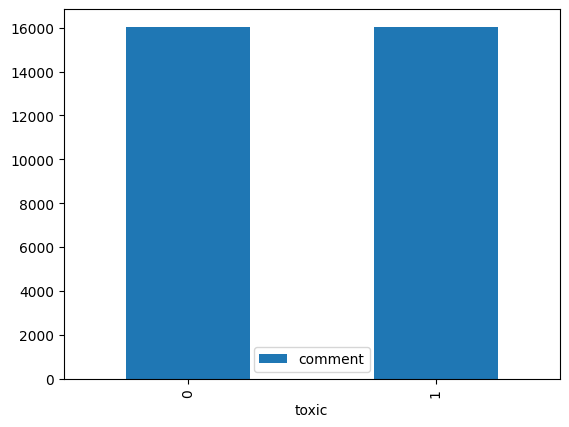

In [37]:
data.groupby('toxic').count().plot(kind = 'bar');

Перфекто

In [38]:
data['toxic'].value_counts()

toxic
0    16038
1    16038
Name: count, dtype: int64

Не забываем удалить дубликаты!!!

In [39]:
duplicates = data[data['comment'].duplicated(keep=False)]

In [40]:
duplicates

,comment,toxic
170322,расстрелять,1
125026,гореть ему в аду,1
231060,расстрелять нах,1
3012,гореть ему в аду,1
97336,расстрелять нах,1
226446,расстрелять нахуй,1
31272,сжечь ведьму,1
145280,расстрелять нахуй,1
197499,тварь,1
72271,как кремлебот так обязательно долбоёб извращен...,1


In [41]:
data_train = data.drop_duplicates(subset='comment', keep=False)
data_train

,comment,toxic
0,бесполезно что то пытаться донести так до люде...,0
1,а свиньи разве умеют читать,1
2,червепидорские страны парашной конфедерации к...,1
3,нет это не так я зашёл сюда специально за эт...,1
4,дополнение дентрен та чилийская грязь на ко...,0
...,...,...
228120,видимо дадут но только во второй половине ...,0
72,умничка счастья и здоровья,0
217463,крупные или мелкие,0
121214,реально цены зашкаливают,0


Баланс классов не сломался после удаления дубликатов

In [42]:
data_train['toxic'].value_counts()

toxic
0    16026
1    16022
Name: count, dtype: int64

Возвращаемся к пункту 1: изучаю данные

Посмотрим какой длины чаще всего имеют комментарии (как и ожидалось чаще всего комментарии имеют немного буков, что очевидно стакается с моей внутренней гипотезой о том, что всем влом писать нормальные комменты и чаще всего это что-то из разряда "молодец", "супер", "умница, хорошее видео", "плохое слово, предлог, мат")

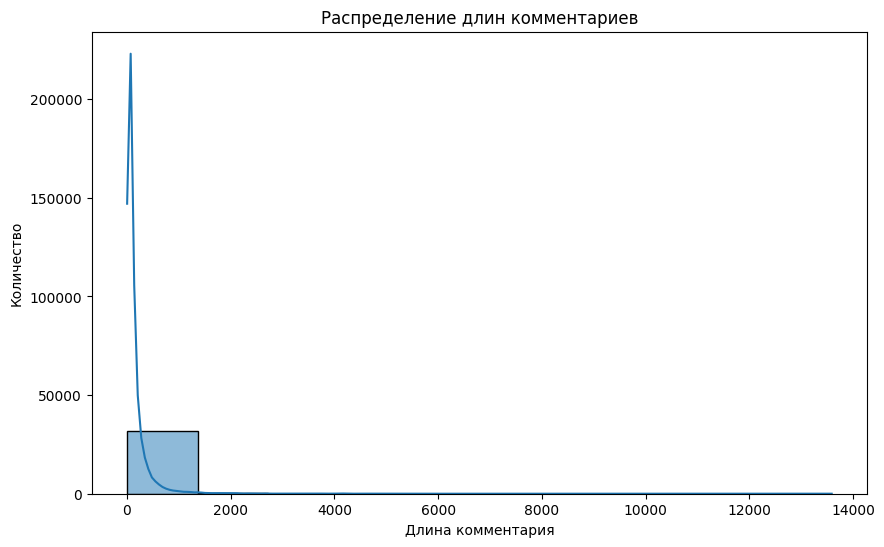

In [43]:
plt.figure(figsize=(10, 6))
sns.histplot(data_train['comment'].apply(len), bins=10 ,kde = True)
plt.title('Распределение длин комментариев')
plt.xlabel('Длина комментария')
plt.ylabel('Количество')
plt.show()

Посмотрим теперь на красивый реверснутый столбцовый график с 30 самыми популярными словами в датасете

In [44]:
all_words = ' '.join(data_train['comment'])
all_words = word_tokenize(all_words)
word_freq = Counter(all_words)
common_words = word_freq.most_common(30)
words, counts = zip(*common_words)

Как и ожидалось, классическая история: союзы, предлоги и другие "общие" слова, которые никак не влияют на контекст комментария

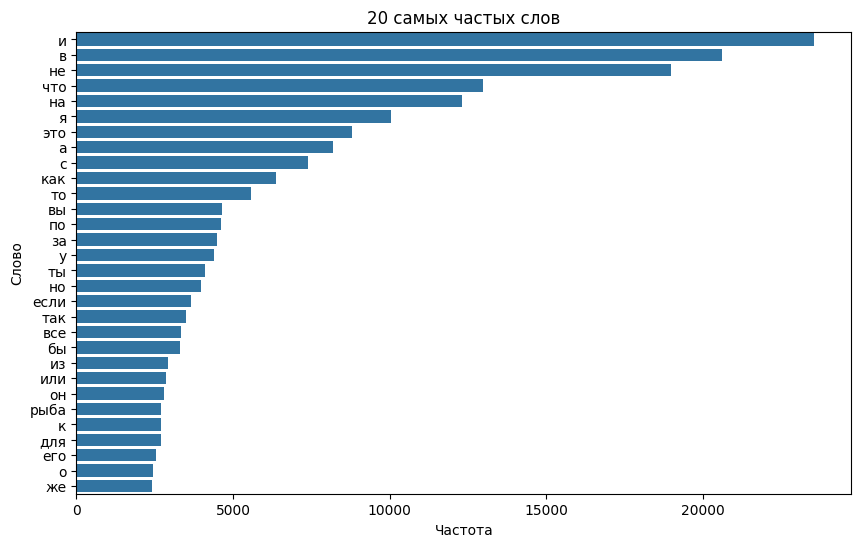

In [45]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title('20 самых частых слов')
plt.xlabel('Частота')
plt.ylabel('Слово')
plt.show()

И еще один красивый график типа "Облако слов"
Тут уже повеселее)))

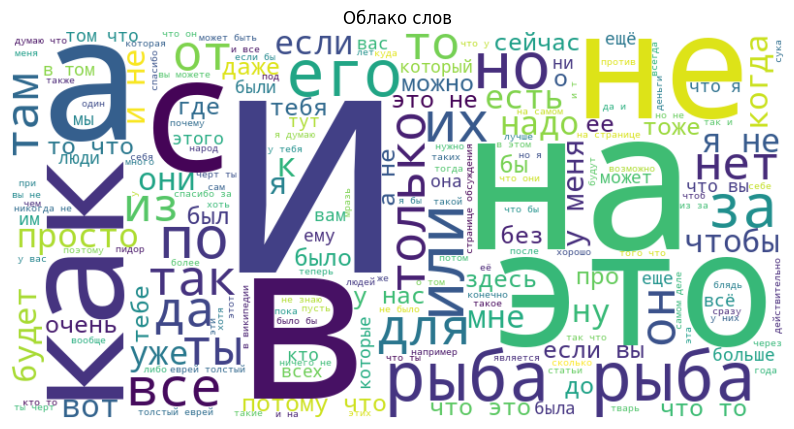

In [46]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов')
plt.show()

Делю датасет на трейн и валидацию (тест уже есть)

In [47]:
train_data, val_data = train_test_split(data_train, test_size=0.2)

In [48]:
train_data

,comment,toxic
10098,тоже самое в детстве ходил на атлетику и как т...,0
118824,я бы взяла белый и бардовый,0
7780,другие регионы будут пусть и мой город небол...,0
234535,дождутся пидоры вся страна поднимется,1
124690,всё просто супер,0
...,...,...
10811,что было расистского в комментариях которые я...,1
19009,вонючка лукашенко называет нашего президента с...,1
4080,тварина конченная ёбнулёнышная единопидросовс...,1
13020,этот фильм я еще в детстве смотрела когда он ...,0


In [49]:
val_data

,comment,toxic
18857,ты себе цену не набивай нужна ты мне как соб...,1
247282,заткнись чучело,1
14327,мерия аким голова,1
227449,как то лично я не очень то и сомневался еще в ...,1
232501,мне нравится твою мать в очко трахать,1
...,...,...
7545,добро пожаловать здравствуйте и добро пожало...,0
3572,вертолёта в тред промытым фемовыблядкам просв...,1
72763,этот гандон и был тронутым просто все пидорас...,1
10086,слышь пидр тебя ебет какие там земли заткнись...,1


In [50]:
data_test

,id,comment
0,15000,или эти программисты зарабатывающие кк с все...
1,15001,с коррекцией т е в очках или линзах
2,15002,да здесь все идет это моя страница обсуж...
3,15003,да но отчасти в этом есть вина и самой теслы ...
4,15004,нужен баланс между труд отдых зачем бывали сл...
...,...,...
5407,20407,кроме того в комплектацию входят прибор ночно...
5408,20408,на самом деле вся эта статья нуждается в дора...
5409,20409,фиговый регистратор можно и часа вместить на ...
5410,20410,я не из бедной семьи но в подростковом возрас...


# 3) Провести собственный препроцессинг данных (лемматизация или стемматизация), создать свой токенайзер. Написать хороший даталоадер

In [51]:
morph = pymorphy2.MorphAnalyzer()

In [52]:
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
def preprocess_text(text):
    tokens = text.split()
    lemmas = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    return ' '.join(lemmas)

In [54]:
tqdm.pandas()

In [55]:
train_data['comment'] = train_data['comment'].progress_apply(preprocess_text)
val_data['comment'] = val_data['comment'].progress_apply(preprocess_text)

100%|██████████| 6410/6410 [00:17<00:00, 366.38it/s]


In [56]:
data_test['comment'] = data_test['comment'].progress_apply(preprocess_text)

100%|██████████| 5412/5412 [00:25<00:00, 216.10it/s]


In [57]:
all_words = ' '.join(train_data['comment'])
all_words = word_tokenize(all_words)
word_freq = Counter(all_words)
common_words = word_freq.most_common(30)
words, counts = zip(*common_words)

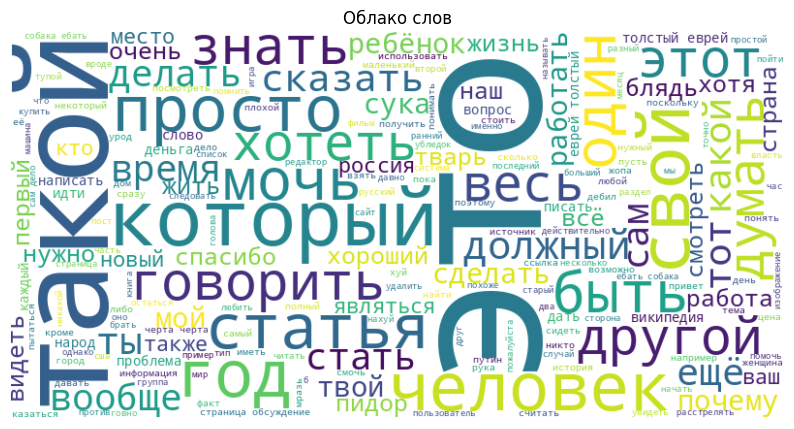

In [58]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов')
plt.show()

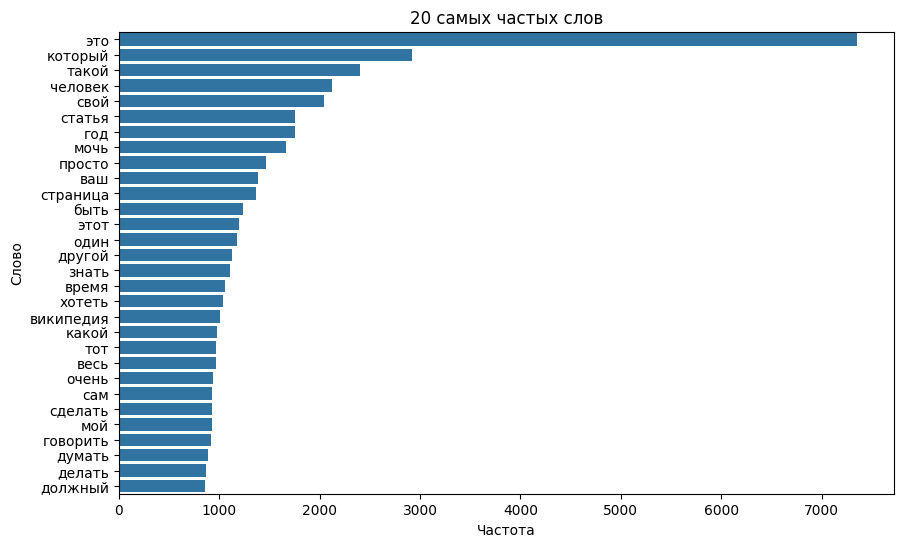

In [59]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title('20 самых частых слов')
plt.xlabel('Частота')
plt.ylabel('Слово')
plt.show()

In [60]:
val_data

,comment,toxic
18857,цена набивать нужный собака пятый нога пробить...,1
247282,заткнуться чучело,1
14327,мерия аким голова,1
227449,лично очень сомневаться г укропия выйти залади...,1
232501,нравиться твой мать очко трахать,1
...,...,...
7545,добро пожаловать здравствуйте добро пожаловать...,0
3572,вертолёт тред промыть фемовыблядок просвещатьс...,1
72763,гандон тронутый просто пидорас рука сходить,1
10086,слышь пидра ебета какой земля заткнуться соват...,1


In [61]:
train_data

,comment,toxic
10098,самый детство ходить атлетика присниться переп...,0
118824,взять белый бардовый,0
7780,другой регион быть пусть город небольшой немал...,0
234535,дождаться пидор весь страна подняться,1
124690,всё просто супер,0
...,...,...
10811,расистский комментарий который оставить видно ...,1
19009,вонючка лукашенко называть наш президент старш...,1
4080,тварин кончить ёбнулёнышный единопидросовский,1
13020,фильм детство смотреть выйти экран спасибо фил...,0


In [62]:
data_test

,id,comment
0,15000,программист зарабатывать кк знающий делать дес...
1,15001,коррекция так быть очки линза
2,15002,идти это страница обсуждение плевать
3,15003,отчасти вино сам теслый раздувать миф тесло са...
4,15004,нужный баланс труд отдых бывать случай умирать...
...,...,...
5407,20407,кроме комплектация входить прибор ночной виден...
5408,20408,сам дело весь этот статья нуждаться доработка ...
5409,20409,фиговый регистратор час вместить гб приличный ...
5410,20410,бедный семья подростковый возраст постоянно хл...


Обучать свой токенайзер, вордтувеки и тд и тп несильно хочу, потому что результат предобученной модели будет лучше) Поэтому перейду к пункту 8, выкачаю модель с [HuggingFace](https://huggingface.co/s-nlp/russian_toxicity_classifier?text=Ты+мне+нравишься.+Я+тебя+люблю), которая уже умеет решать такие задачки и сделаю трансфер ленинг

In [63]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')
model = BertForSequenceClassification.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Создаю даталоадеры для трейна и валидации

In [64]:
class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [65]:
train_dataset = ToxicCommentsDataset(
    texts=train_data['comment'].tolist(),
    labels=train_data['toxic'].tolist(),
    tokenizer=tokenizer
)

In [66]:
val_dataset = ToxicCommentsDataset(
    texts=val_data['comment'].tolist(),
    labels=val_data['toxic'].tolist(),
    tokenizer=tokenizer
)

In [67]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [69]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

In [70]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_loader) * 2
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Честно говоря, код для тренировки какая-то шляпа, пытался сделать по-человечески, но получилось несильно хорошо, поэтому пусть работает, как работало

In [71]:
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    losses = []
    correct_predictions = 0
    for d in tqdm(data_loader, desc="Training"):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        preds = torch.argmax(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

In [72]:
def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in tqdm(data_loader, desc="Evaluating"):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            preds = torch.argmax(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

In [73]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs=2):
    history = {
        "train_acc": [],
        "train_loss": [],
        "val_acc": [],
        "val_loss": []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_acc, train_loss = train_epoch(model, train_loader, optimizer, device, scheduler)
        val_acc, val_loss = eval_model(model, val_loader, device)

        history["train_acc"].append(train_acc)
        history["train_loss"].append(train_loss)
        history["val_acc"].append(val_acc)
        history["val_loss"].append(val_loss)

        print(f"Train loss {train_loss} accuracy {train_acc}")
        print(f"Val loss {val_loss} accuracy {val_acc}")

    return history

In [74]:
# def train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs=2):
#     history = {
#         "train_acc": [],
#         "train_loss": [],
#         "val_acc": [],
#         "val_loss": []
#     }

#     for epoch in range(num_epochs):
#         print(f"Epoch {epoch + 1}/{num_epochs}")

#         # Training phase
#         model.train()
#         train_losses = []
#         train_correct_predictions = 0
#         for d in tqdm(train_loader, desc="Training"):
#             input_ids = d["input_ids"].to(device)
#             attention_mask = d["attention_mask"].to(device)
#             labels = d["labels"].to(device)

#             outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             preds = torch.argmax(outputs.logits, dim=1)
#             train_correct_predictions += torch.sum(preds == labels)
#             train_losses.append(loss.item())

#             loss.backward()
#             optimizer.step()
#             scheduler.step()
#             optimizer.zero_grad()

#         train_acc = train_correct_predictions.double() / len(train_loader.dataset)
#         train_loss = np.mean(train_losses)

#         # Validation phase
#         model.eval()
#         val_losses = []
#         val_correct_predictions = 0
#         with torch.no_grad():
#             for d in tqdm(val_loader, desc="Validation"):
#                 input_ids = d["input_ids"].to(device)
#                 attention_mask = d["attention_mask"].to(device)
#                 labels = d["labels"].to(device)

#                 outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss
#                 preds = torch.argmax(outputs.logits, dim=1)
#                 val_correct_predictions += torch.sum(preds == labels)
#                 val_losses.append(loss.item())

#         val_acc = val_correct_predictions.double() / len(val_loader.dataset)
#         val_loss = np.mean(val_losses)

#         history["train_acc"].append(train_acc.item())
#         history["train_loss"].append(train_loss)
#         history["val_acc"].append(val_acc.item())
#         history["val_loss"].append(val_loss)

#         print(f"Train loss {train_loss} accuracy {train_acc}")
#         print(f"Val loss {val_loss} accuracy {val_acc}")

#     return history

In [75]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [76]:
#history = train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs=2)

In [77]:
history = train_model(model, train_loader, val_loader, optimizer, scheduler, device)

Epoch 1/2


Evaluating: 100%|██████████| 201/201 [00:43<00:00,  4.67it/s]


Train loss 0.17172085167027248 accuracy 0.9361494656369451
Val loss 0.1408975556613275 accuracy 0.9453978159126365
Epoch 2/2


Evaluating: 100%|██████████| 201/201 [00:42<00:00,  4.69it/s]

Train loss 0.08143941437746595 accuracy 0.9711365941181059
Val loss 0.1522834970666772 accuracy 0.9466458658346334


In [78]:
history

{'train_acc': [tensor(0.9361, device='cuda:0', dtype=torch.float64),
  tensor(0.9711, device='cuda:0', dtype=torch.float64)],
 'train_loss': [0.17172085167027248, 0.08143941437746595],
 'val_acc': [tensor(0.9454, device='cuda:0', dtype=torch.float64),
  tensor(0.9466, device='cuda:0', dtype=torch.float64)],
 'val_loss': [0.1408975556613275, 0.1522834970666772]}

In [79]:
def plot_training_history(history):
    train_acc = [acc.cpu().item() for acc in history['train_acc']]
    val_acc = [acc.cpu().item() for acc in history['val_acc']]
    train_loss = history['train_loss']
    val_loss = history['val_loss']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Тренировочные лоссы')
    plt.plot(epochs, val_loss, 'ro-', label='Валидационные лоссы')
    plt.title('Лоссы во время тренировки и валидации')
    plt.xlabel('Эпохи')
    plt.ylabel('Лоссы')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Тренировочная аккураси')
    plt.plot(epochs, val_acc, 'ro-', label='Валидационная аккураси')
    plt.title('Аккураси во время тренировки и валидации')
    plt.xlabel('Эпохи')
    plt.ylabel('Аккураси')
    plt.legend()

    plt.show()

Тяжело делать выводы на двух эпохах, но лосс на валидации увеличился - это плохо( Но при этом подрос аккураси на валидации, что хорошо, возможно, достаточно обучить и на одной эпохе, или же наоборот, запустить побольше, чтобы посмотреть насколько модель стабильна, но это уже совсем другая история

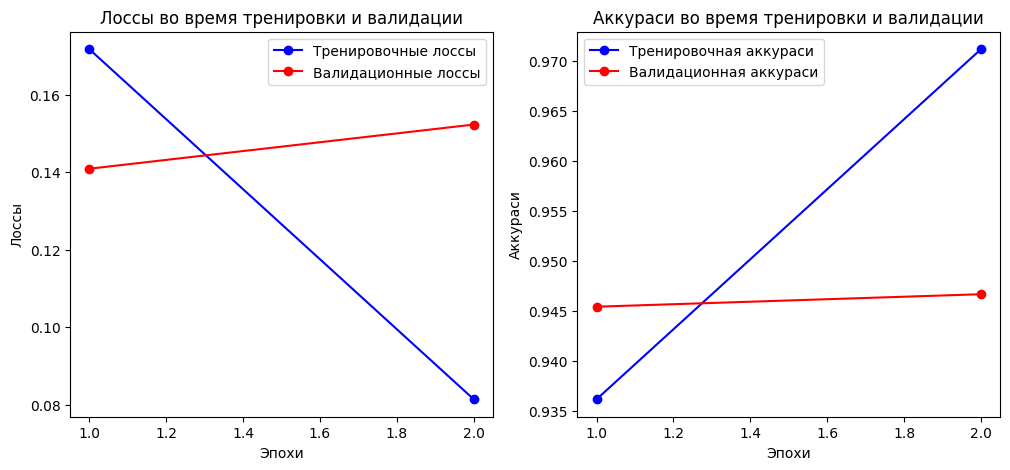

In [80]:
plot_training_history(history)

In [81]:
class ToxicCommentsTestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [82]:
test_dataset = ToxicCommentsTestDataset(
    texts=data_test['comment'].tolist(),
    tokenizer=tokenizer
)

In [83]:
test_loader = DataLoader(test_dataset, batch_size=32)

In [84]:
def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for d in tqdm(data_loader, desc="Predicting"):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())

    return predictions

In [85]:
predictions = get_predictions(model, test_loader)

Predicting: 100%|██████████| 170/170 [00:39<00:00,  4.31it/s]


In [86]:
predictions

[0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [87]:
submission = pd.DataFrame({
    'ID': data_test['id'],
    'prediction': predictions
})

In [88]:
submission

,ID,prediction
0,15000,0
1,15001,0
2,15002,0
3,15003,0
4,15004,0
...,...,...
5407,20407,0
5408,20408,0
5409,20409,0
5410,20410,0


In [89]:
submission = pd.DataFrame({
    'ID': data_test['id'],
    'prediction': predictions
})

In [91]:
submission.to_csv('submission_serdyukov_3.csv', index=False)

аккураси на паблик части ~ 90%